# import libraries

In [1]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(utl)

<module 'utility' from '/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/utility.py'>

# Parameters

In [2]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path') #--- don't comment!
indx = int(os.environ.get('indx'))
temperature = int(eval(os.environ.get('temperature')))

In [14]:
#--- comment out parameters if you pass them
#--- by arguments

Displ = False
#
PressFluc = False
#
VorAnl = False
#
PairCrltnFunc = False
#
NeighList = True
cutoff = 8.0 #5.5 # * rpeak #--- 1st peak=2.5
#
Ovitos = True #--- don't change!
#
SroParameter = False
#
DislocAnl = True 
#
nevery = 2 #--- postproc. every n times
#
RemoteMachine = True #--- tex issue: don't run corresponding cells
#
mass={1:58.693, # Ni
      2:58.933195, # Co
      3:51.9961 #Cr
     } 

# 'Co', 'Ni', 'Cr', 'Fe', 'Mn'
# AtomicRadius = {2:1.35, # Co
#                 1:1.35, #Ni
#                 3:1.4 #Cr
#                 } #--- https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)

AtomicRadius = {2:1.252, # Co
                1:1.244, #Ni
                3:1.267 #Cr
                } #--- https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-10012-7/MediaObjects/41467_2019_10012_MOESM1_ESM.pdf

#--- lammps output
#path = '/Users/Home/Desktop/Tmp/txt/sheared'
#indx=8

#--- lammps dump/data files: ref. state
fileName = '%s/%s'%(path,{
            0:'DumpFile.xyz',
            1:'dumpThermalized.xyz',
            2:'dumpSheared.xyz',
            3:'shear1300MPa_sheng_Annealed_600.dump',
            4:'dumpInit.xyz',
            5:'Swapped_800.dump',
            6:'Swapped_800-10.dump',
            7:'Swapped_%s.dump'%temperature,
            8:'shear700MPa_sheng.dump',
            9:'dump.shearedge5k_Sheng5_anealed_500load',
            }[indx])#--- parse cords

In [31]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


# Dump File

In [217]:
#--- dump files
lmpData = lp.ReadDumpFile( fileName ) 
lmpData.GetCords( ncount = sys.maxsize, 
#                 columns = {'c_1[1]':'sxx','c_1[2]':'syy','c_1[3]':'szz',
#                                                   'c_1[4]':'sxy','c_1[5]':'sxz','c_1[6]':'syz'} 
#                  columns = {'c_mystress[1]':'sxx','c_mystress[2]':'syy','c_mystress[3]':'szz',
#                             'c_mystress[4]':'sxy','c_mystress[5]':'sxz','c_mystress[6]':'syz'}
                )


> /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/LammpsPostProcess.py(96)GetCords()
     94                 pdb.set_trace()
     95                 #--- insert in a data frame
---> 96                 self.coord_atoms_broken[ itime ] = pd.DataFrame( np.c_[sarr].astype('float'), columns = cols )
     97 
     98                 #--- cast id and type to 'int'

ipdb> sarr
array([['2', '2', '0.719774', '0.923014', '-0.958965'],
       ['7', '3', '2.48804', '0.794213', '0.899183'],
       ['124', '3', '0.564081', '2.62299', '0.556633'],
       ...,
       ['107998', '1', '104.953', '104.833', '103.314'],
       ['107999', '1', '103.008', '104.937', '105.115'],
       ['108000', '2', '104.89', '103.127', '105.116']], dtype='<U9')
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/LammpsPostProcess.py(94)GetCords()
     92             while True and count <= ncount:
     93                 sarr, cell_vector, itime, cols  = sel

Traceback (most recent call last):
  File "/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/LammpsPostProcess.py", line 94, in GetCords
    #                pdb.set_trace()
  File "/usr/local/lib/python3.9/site-packages/pandas/core/base.py", line 733, in tolist
    return self._values.tolist()
KeyboardInterrupt


In [35]:
lmpData.coord_atoms_broken.keys()

dict_keys([0])

## stress response

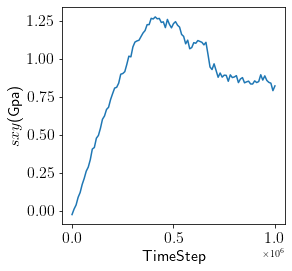

In [22]:
def GetStrsStrain( lmpData, col='sxy' ):

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'TimeStep',fontsize=16)
    ax.set_ylabel(r'$%s$(Gpa)'%col,fontsize=16)
    ax.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
    ax.plot(
            sorted(times),
            Virial, '-')
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    #

    

GetStrsStrain( lmpData,
              col='sxy',
             )


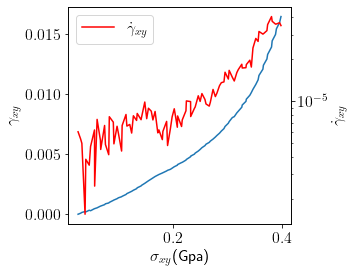

In [14]:
def GetStrsStrain( lmpData, col='sxy' ):

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax2=ax.twinx()
    #
    ax.set_xlabel(r'$\sigma_{xy}$(Gpa)',fontsize=16)
    ax2.set_ylabel(r'$\dot\gamma_{xy}$',fontsize=16)
    ax.set_ylabel(r'$\gamma_{xy}$',fontsize=16)
    #
    ax2.set_yscale('log')
    #
    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False
    #        virial = -(np.sum(atoms.sxx)+np.sum(atoms.syy)+np.sum(atoms.szz)) / 3.0 / volume

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
    ax.plot(
            sorted(Virial),
            strainDump, '-',label=r'$\gamma_{xy}$')
    ax2.plot(
            sorted(Virial),
            np.gradient(strainDump,sorted(times)), 
            '-',color='red',label=r'$\dot\gamma_{xy}$')
    #
    plt.legend(fontsize=16)
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    #

GetStrsStrain( lmpData,
              col='sxy',
             )


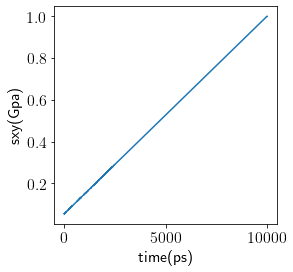

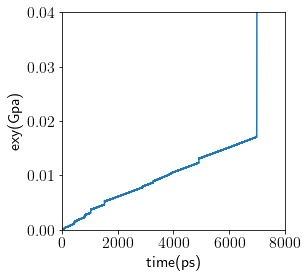

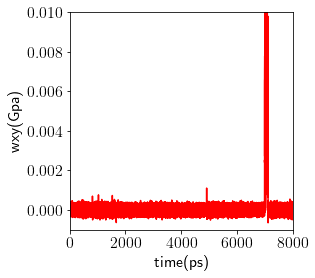

In [8]:
def GetStrsStrain( filee, xcol, ycol, **kwargs ):
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'%s(ps)'%xcol,fontsize=16)
    ax.set_ylabel(r'%s(Gpa)'%ycol,fontsize=16)
    #
    ax.tick_params(labelsize=16)
    #
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs['xlim'])
    #
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs['ylim'])
    #
    if 'xscale' in kwargs:
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs:
        ax.set_yscale(kwargs['yscale'])
    #
    df = pd.read_csv(filee,sep=' ')
    try:
        ax.plot(
                df[xcol],
                df[ycol], '-')
    except:
        if ycol == 'wxy':
            ax.plot(
                    df[xcol],
                    np.gradient(df['exy'],df['time']), 
                    '-',color='red',label=r'$\dot\gamma_{xy}$')
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    
GetStrsStrain( '%s/temperature.txt'%path,
               xcol = 'time',
               ycol = 'sxy',
             
             )

GetStrsStrain( '%s/temperature.txt'%path,
               xcol = 'time',
               ycol = 'exy',
              xlim=np.array([0.0,.8])*10000,
              ylim=[0.0,0.04]             
             )

GetStrsStrain( '%s/temperature.txt'%path,
               xcol = 'time',
               ycol = 'wxy',
              xlim=np.array([0.0,0.8])*10000,
              ylim=[-1e-3,1e-2],
              xscale = 'linear', yscale = 'linear',
             )

## parse data

In [58]:
#itimee=np.sum(list(lmpData.coord_atoms_broken.keys())) #--- only two timesteps:[0,ntime]
itimee=list(lmpData.coord_atoms_broken.keys())[-1] #--- only two timesteps:[0,ntime]
atomsRf = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series') )
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='series') )
    #
box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ) )
#box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    
display(pd.DataFrame(atoms.__dict__).head())
pd.DataFrame(atomsRf.__dict__).head()


,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz
0,-0.35922,-0.12266,-0.027906,1,3,1697000.0,-154800.0,-141200.0,395600.0,-461700.0,-139700.0
1,1.58640,1.70510,-0.083093,2,2,-906900.0,-153400.0,-467700.0,199800.0,-886200.0,168500.0
2,1.34640,-0.10109,1.751200,3,2,-1190000.0,-335000.0,289400.0,-519800.0,-780600.0,102900.0
3,-0.26086,1.74900,1.854300,4,3,-156500.0,-785900.0,634300.0,744900.0,16560.0,101000.0
4,3.39230,-0.23682,-0.089466,5,3,1534000.0,628700.0,871400.0,-450100.0,-1245000.0,43890.0


,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz
0,-0.11174,-0.27314,-0.27766,1,3,822200.0,1997000.0,807400.0,-105700.0,362200.0,78270.0
1,1.47830,1.69290,-0.20853,2,2,-742800.0,-1418000.0,-517800.0,-170400.0,-546800.0,-483400.0
2,1.63120,-0.29358,1.41830,3,2,-107900.0,134400.0,-602800.0,260600.0,335700.0,-284700.0
3,-0.18963,1.46830,1.64840,4,2,-101300.0,240000.0,36450.0,-59700.0,375000.0,-106800.0
4,3.32740,0.00303,-0.14792,5,2,-425300.0,-409900.0,81350.0,-43770.0,340900.0,-90320.0


In [59]:
lmpData.coord_atoms_broken.keys()

dict_keys([0, 1000, 2000, 3000, 4000])

In [60]:
itimee

4000

In [89]:
# wrap = lp.Wrap(atoms,box)
# wrap.WrapCoord()
# wrap.Set( atoms )
# wrap = lp.Wrap(atoms,box)
# assert np.all(wrap.isInside()), 'aotms outside original box!'


In [48]:
# box.__dict__

In [49]:
# box.CellOrigin -= np.array([1,1,1])
# box.SetBoxBounds()
# box.__dict__

## removed atom

In [10]:
# atom_id=np.sum(atomsRf.id)-np.sum(atoms.id)
# print('atom_id=',atom_id)
# zz=pd.DataFrame(atomsRf.__dict__)[pd.DataFrame(atomsRf.__dict__)['id']==atom_id]['z'].iloc[0]

In [11]:
# PrintOvito( pd.DataFrame(atomsDiff.__dict__), 
#             open( 'strsDiff.xyz','w'), 
#             footer = 'ITIME=%s'%itimee,
#             attr_list=['id','type','x','y','z','sxx' ,'syy' ,'szz' ,'sxy' ,'sxz' ,'syz'] )

# Displacements

In [16]:
if Displ and Ovitos:
    !ovitos OvitosCna.py $fileName Disp.xyz $nevery 4
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Disp.xyz' )
    ovtData.GetCords( ncount = sys.maxsize, 
                     columns = {'DisplacementX':'ux','DisplacementY':'uy','DisplacementZ':'uz'} )
    #
    disp = lp.Atoms( **ovtData.coord_atoms_broken[itimee].to_dict(orient='series'))


# Voronoi Analysis

In [61]:
if VorAnl and Ovitos:
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    !ovitos OvitosCna.py $fileName Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)

InputFile= /Users/Home/Desktop/Tmp/txt/Swapped_600.0.dump
num_frames= 5


# Press. Fluc

In [62]:
def StrsDiff(atoms,atomsRf):
    atomsDiff = lp.Atoms( **pd.DataFrame(atoms.__dict__).copy().to_dict(orient='series'))
    atoms0 = lp.Atoms( **pd.DataFrame(atomsRf.__dict__).copy().to_dict(orient='series'))
    #--- virial energy to stress
    for key in ['sxx','syy','szz','sxy','syz','sxz']:
        atomsDiff.__dict__[key] /= atomsDiff['AtomicVolume']
        atoms0.__dict__[key] /= atoms0['AtomicVolume']
    df=pd.DataFrame(atoms0.__dict__).set_index('id').loc[atoms.id]
    #--- stress change
#    for key in ['sxx','syy','szz','sxy','syz','sxz','AtomicVolume']:
#        atomsDiff.__dict__[key] -= np.array((df[key]).tolist())
        
    #--- volumetric strain
#    atomsDiff.AtomicVolume /= atoms0.AtomicVolume
#    display(pd.DataFrame(atomsDiff.__dict__))
    return atomsDiff

if PressFluc:
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[itimee]['type'])),
                       AtomicVolume = ovtData.coord_atoms_broken[itimee]['AtomicVolume'].tolist(),
                    )
    #---
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[0]['type'])),
                       AtomicVolume = ovtData.coord_atoms_broken[0]['AtomicVolume'].tolist(),
                    )

    display(pd.DataFrame(atoms.__dict__).head())
    
    #--- pressure change
#    atomd=StrsDiff(atoms,atoms0) #--- atomd.sxx has units of stress 
    #--- filter abs(dv)>0
#    atomd = lp.Atoms( **pd.DataFrame(atomd.__dict__)[np.abs(atomd.AtomicVolume)>1.0e-10].to_dict(orient='series'))
#    display(pd.DataFrame(atomd.__dict__).head())

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume,rad
0,-0.35922,-0.12266,-0.027906,1,3,1697000.0,-154800.0,-141200.0,395600.0,-461700.0,-139700.0,11.219697,1.267
1,1.58640,1.70510,-0.083093,2,2,-906900.0,-153400.0,-467700.0,199800.0,-886200.0,168500.0,11.609668,1.252
2,1.34640,-0.10109,1.751200,3,2,-1190000.0,-335000.0,289400.0,-519800.0,-780600.0,102900.0,11.385121,1.252
3,-0.26086,1.74900,1.854300,4,3,-156500.0,-785900.0,634300.0,744900.0,16560.0,101000.0,11.056122,1.267
4,3.39230,-0.23682,-0.089466,5,3,1534000.0,628700.0,871400.0,-450100.0,-1245000.0,43890.0,11.775809,1.267


## Scatter plot

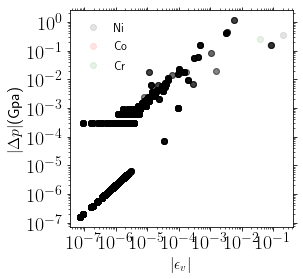

In [124]:
def PlotScatter(atomd,**kwargs):
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    #
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    y=np.array(atomd.sxx)+np.array(atomd.syy)+np.array(atomd.szz)
    y *= (-1.0e-4/3.0)
    x = np.array(atomd.AtomicVolume)
    
    cxy=0.0
    if 'zscore' in kwargs and kwargs['zscore']:
        x = Zscore(x)
        y = Zscore(y)
        cxy = np.sum(x*y)/len(x)
    for elm,indxx,col in zip(['Ni','Co','Cr'],[1,2,3],['black','red','green']):
        filtr = np.array(atomd.type) == indxx
        ax.scatter(np.abs(x[filtr]),np.abs(y[filtr]),
                   alpha=.1,c=col,label=elm)#,marker='x')
    #
    ax.legend(frameon=False, fontsize=12)
    #
#     DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    PutMinorTicks( ax, LOGY = True, LOGX=True)
    #
    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    return cxy
    
    

if PressFluc and VorAnl and not RemoteMachine:
    cxy = PlotScatter(atomd,
#               zscore = True,
#               xlim=[1e-7,1e-3,1e-8,1e4],
               Logx=True, Logy=True,
               ylabel = r'$|\Delta p|$(Gpa)',
               xlabel = r'$|\epsilon_v|$',
               )
    np.savetxt('PressVolCrltn.txt',[cxy],header='<p.v>')

In [14]:
# plt.hist(np.array(atoms.AtomicVolume)-np.array(atoms0.AtomicVolume),bins=64)
# plt.yscale('log')
# plt.show()

In [15]:
# y=np.array(atoms0.sxx)+np.array(atoms0.syy)+np.array(atoms0.szz)
# y/=atoms0.AtomicVolume
# y *= (-1.0e-4/3.0)
# plt.hist(y,bins=64)
# plt.yscale('log')
# plt.show()

## Mean pressure

In [15]:
press=np.sum(np.array(atoms.sxx)+np.array(atoms.syy)+np.array(atoms.szz))
vol = np.linalg.det(box.CellVector)
press *= (-1.0e-4/3.0/vol)

press0=np.sum(np.array(atoms0.sxx)+np.array(atoms0.syy)+np.array(atoms0.szz))
vol = np.linalg.det(box.CellVector)
press0 *= (-1.0e-4/3.0/vol)

print('dp=',press-press0)
np.savetxt('PressChange.txt',[press-press0],header='DeltaPress')


dp= -6.698578684752962


### multiple frames

In [14]:
if not RemoteMachine:
    sarr = MultipleFrames2nd( path='NiCoCrNatom100KTakeOneOutRlxd', title='PressChange.txt', nrun = 16, ncols=1 ).flatten()

    plt.hist(sarr,bins=16)
    plt.show()
    
    print(sarr.mean(),sarr.std()/np.abs(sarr.mean()))

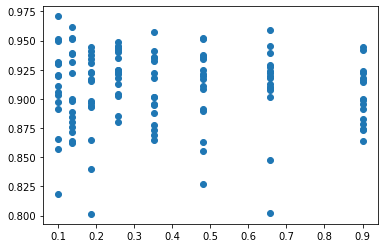

In [18]:
# fraci = np.logspace(np.log10(0.1),np.log10(0.9),8)
# for ifrac, fracc in zip(range(1000),fraci):
#     sarr  = MultipleFrames2nd(path='HeaNiCoCrNatom10KTakeOneOutFreezeFract%sRlxd'%ifrac,
#                               nrun=32,title='PressVolCrltn.txt',ncols=1).flatten()
#     indices = ~np.isnan( sarr )
#     sarr = sarr[ indices ]
#     plt.scatter([fracc]*len(sarr),-sarr,color='C0')
# plt.show()

## pressure decay

### map

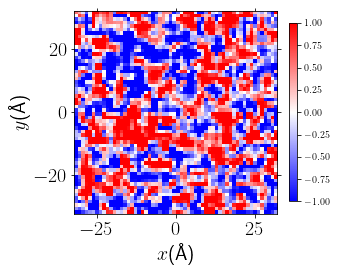

In [65]:
def Intrp( d2min, box0,times, time0, Plot = None ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.3, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

    if Plot:
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        #--- xy plane
        zz=0.5*(zlin[-1]+zlin[0])
        dz = zlin[-1]-zlin[-2]
        lz = zlin[-1]-zlin[0]
        nzz=int(nz*(zz-zlin[0])/lz)
        val = value[:,:,nzz].copy()
#        pdb.set_trace()

        np.savetxt('pressBitmap.txt',val)

        PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = True,
                  frac = 0.5, #--- plot a patch
                  title = 'd2min.png',
                  colorbar=True,
                )

    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp
  
if not RemoteMachine:
    junk, (xv, yv, zv), d2intrp = Intrp(atoms, box,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                   )

#### map and scatterd plot 

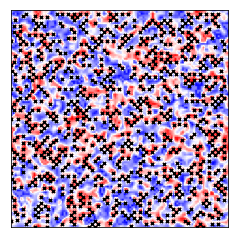

In [76]:
def PltBitmapWithScatter( value, xyScatter,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              ticklabels=True,
              color='black',
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4*aspect))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
    if not ticklabels:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=color,marker='x',s=10)
        
        
    if colorbar:
        ax.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
def Intrp( d2min, box0,times, time0, title = 'bitmap', Plot = None ):
    d2intrp = {}
    for itime in times:
        #--- mean dist between atoms 
        natoms = len( d2min.x ) 
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


        #--- grid tiling mapped box with original size
        #--- values are interpolated onto this grid
        (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                         box0.CellVector, 
                                                         dmean,
                                                         margin = 0.0 * dmean )
        xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

        #--- expand the original box
            #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
        cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
        d2exp = cptmp.Get()

        points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
        values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0] #--- corresponding values

        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

        #--- make an object
        d2intrp[ itime ] = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

        if Plot:
        #--- reshape value
            nx,ny,nz = len(xlin), len(ylin),len(zlin) 
            value = np.c_[d2intrp[ itime ].d2min].reshape(((ny,nx,nz)))

            CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
            #--- xy plane
#            zz=0.0
            zc=0.5*(zlin[0]+zlin[-1])
            dz = zlin[-1]-zlin[-2]
            lz = zlin[-1]-zlin[0]
            #
            zz = [zc,zlin[-1]][1]
            nzz=int(nz*(zz-zlin[0])/lz)
            if nzz == nz: nzz -= 1
            val = value[:,:,nzz].copy()
#            pdb.set_trace()
        
#            np.savetxt('pressBitmap.txt',val)

#             PltBitmap(val, 
#                       xlabel = 'x', ylabel = 'y',
#                       xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#                       zscore = True,
#                       frac = 1.0, #--- plot a patch
#                  title = '%s%s.png'%(title,itime),
#                       colorbar=True,
#                     )
            
            #--- filter
            zlo=(zz-dz-zlin[0]) % lz + zlin[0]
            zhi=(zz+dz-zlin[0]) % lz + zlin[0]

            indxx= np.all([d2min.z > zlo, 
                           d2min.z < zhi
                          ],
                            axis=0)
            
            if zhi < zlo: #--- periodicity
                indxx= np.any([d2min.z > zlo, 
                               d2min.z < zhi
                              ],
                                axis=0)


            indices = d2min.type == 1 #--- Ni 3
            indxx = np.all([indxx,indices],axis=0)

            PltBitmapWithScatter(val, 
                  np.c_[np.array(d2min.x)[indxx],np.array(d2min.y)[indxx]],
                  xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                  xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                  zscore = True,
                  frac = 1.0, #--- plot a patch
                  title = '%s%s.png'%(title,itime),
                  colorbar=None,
                  ticklabels = None,
                  color='black',
    #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                  )
                
                

    return (xlin, ylin, zlin), (xv[:,:,:], yv[:,:,:], zv[:,:,:]), d2intrp
  
if not RemoteMachine:
    junk, (xv, yv, zv), d2intrp = Intrp(atoms0, box,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                    title = 'cr',
                   )

In [93]:
pd.DataFrame(atoms0.__dict__)

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume,rad
0,-73.654295,-60.037268,-8.262945,1,1,-528300.0,-1191000.0,-2711000.0,634800.0,93870.0,-374400.0,4.586078,1.244
1,-73.661756,-58.008367,-5.388877,2,1,-950800.0,-2956000.0,-3449000.0,-17470.0,-9558.0,-827700.0,9.016695,1.244
2,-73.669569,-55.979563,-6.825912,3,1,-991900.0,-3131000.0,-3674000.0,-43880.0,-22840.0,-898100.0,8.966734,1.244
3,-72.413537,-58.005041,-7.544428,4,1,-6796000.0,66960.0,105100.0,3038.0,-12270.0,-67710.0,10.381232,1.244
4,-72.421304,-55.976247,-4.670361,5,1,-7377000.0,85930.0,75520.0,7343.0,-5939.0,-77520.0,10.358419,1.244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,71.945080,57.838425,7.544428,28796,1,56490.0,353200.0,321800.0,86920.0,35860.0,202000.0,11.781134,1.244
28796,71.953132,59.874335,6.107394,28797,1,396600.0,351300.0,976800.0,100600.0,-91620.0,88180.0,7.342673,1.244
28797,73.185628,57.834908,5.388877,28798,1,464000.0,1110000.0,1062000.0,-32610.0,-15730.0,-59240.0,11.957465,1.244
28798,73.193735,59.870809,8.262945,28799,1,884600.0,886200.0,1306000.0,331900.0,-58290.0,-35060.0,7.263248,1.244


#### average map

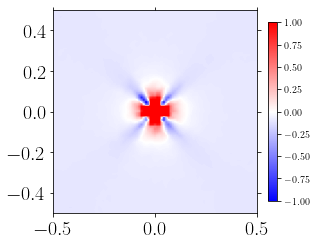

In [267]:
if not RemoteMachine:
    nruns=16
    for irun in range(nruns):
        val=np.loadtxt('NiCoCrNatom100KTakeOneOutRlxd/Run%s/pressBitmap.txt'%irun)
        if irun == 0:
            valm = val.copy()
        else:
            valm += val
    valm /= nruns

    PltBitmap(valm, 
              xlabel = '', ylabel = '',
    #          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = 'd2min.png',
              colorbar=True,
    #          DrawFrame=[0.3,0.3,0.3,0.1,0.1],
            )

### scaling

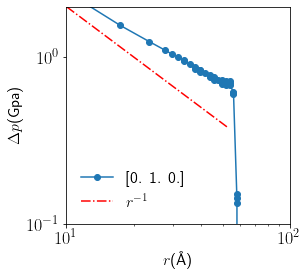

In [97]:
def GetCR( X, Y, Z, zfield, DIR, tol=1e-3, title='decay.png',**kwargs ):
    if 'xc' in kwargs:
        X = X.copy()
        Y = Y.copy()
        Z = Z.copy()
        xc = kwargs['xc']
        X -= xc[0]
        Y -= xc[1]
        Z -= xc[2]
    xyz = np.c_[X,Y,Z]
    xyzNorm = np.array(list(map(lambda x: np.sum(x)**.5,xyz*xyz)))
    #
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.tick_params(labelsize=18)
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)
    #
    for ndir in DIR:
        dot = np.sum(xyz * ndir,axis=1) / np.sum(ndir*ndir)**0.5 / xyzNorm
        assert np.all([-1.0<=dot,dot<=1.0])
        #
        indices= np.abs(1.0-dot) < tol
        #
        xx=X[indices]
        yy=Y[indices]
        zz=Z[indices]
    #    print(np.c_[xx,yy,zz])
        #
        rr=np.sqrt(xx*xx+yy*yy+zz*zz)
        rho = zfield[indices]
        assert len( rr ) > 0 
        assert len(rho[np.isnan(rho)]) == 0
        #
        slist=list(zip(rr,rho))
        slist.sort()
        rr = [i[0] for i in slist]
        rho = [i[1] for i in slist]
        ax.plot(rr,rho,'-o',label=r'%s'%ndir)
#        print(np.c_[rr,rho])
    #
    #--- draw power law
    if 'alpha' in kwargs:
        alpha = kwargs['alpha']
        xx=ax.lines[0].get_data()[0]
        xx.sort()
        xx = np.array(xx)
        ax.plot(ax.axis()[0]*(xx/xx[0]),ax.axis()[3]*(xx[0]/xx)**alpha,'-.r',label='$r^{-%s}$'%alpha)
        #
        ax.legend(frameon=False, fontsize=16)
    #--- save
    if 'Logy' in kwargs and kwargs['Logy']:
        PutMinorTicks(ax, LOGY=True)
    if 'Logx' in kwargs and kwargs['Logx']:
        PutMinorTicks(ax, LOGX=True)
    #DrawFrame(ax, 0.3,0.3,0.3,0.1,0.1)
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    
    
if not RemoteMachine:

    #--- binning
    valm = -1.0e-4*(atoms.sxx+atoms.syy+atoms.szz)/atoms.AtomicVolume/3.0 #--- corresponding values
    GetCR( atoms.x, atoms.y, atoms.z, valm, 
    #      np.array([[1.0,1.0,0.0],[-1.0,1.0,0.0],[-1.0,-1.0,0.0],[1.0,-1.0,0.0]] ),
    #      np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[-1.0,0.0,0.0],[0.0,-1.0,0.0]] ),
          np.array([[0.0,1.0,0.0]]),#,[1.0,1.0,0.0]] ),
          xc=np.array([28.6,0.0,0.0]), #--- origin
          xlabel=r'$r$(\r{A})',
          ylabel =r'$\Delta p$(Gpa)',
          xlim=(1e1,1e2,1e-1,2),
           Logy = True,
           Logx = True,
          alpha=1,
         )






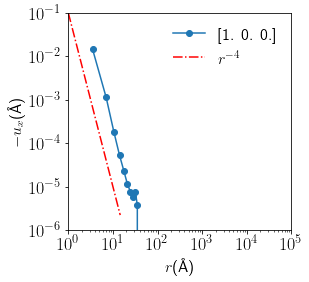

In [94]:
if not RemoteMachine:

    #--- binning
    GetCR( disp.x, disp.y, disp.z, -disp.ux, 
          np.array([[1.0,0.0,0.0]]),
          xlabel=r'$r$(\r{A})',
          ylabel =r'$-u_x$(\r{A})',
          xlim=(1e0,1e5,1e-6,1e-1),
           Logy = True,
           Logx = True,
          alpha=4,
          title='udecay.png'
         )

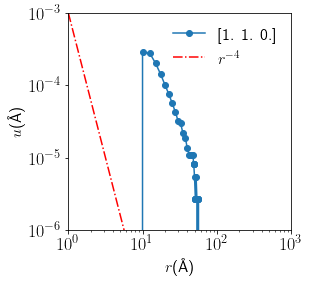

In [97]:
if not RemoteMachine:

    valm=list(map(lambda x: x[0]+x[1],np.c_[disp.ux,disp.uy,disp.uz]* np.array([[1.0,1.0,0.0]])/2**.5))
    GetCR( disp.x, disp.y, disp.z, np.array(valm), 
          np.array([[1.0,1.0,0.0]]),
          xlabel=r'$r$(\r{A})',
          ylabel =r'$u$(\r{A})',
          xlim=(1e0,1e3,1e-6,1e-3),
           Logy = True,
           Logx = True,
          alpha=4,
          title='udecay.png'
         )

## Composition Fluctuations


In [63]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    for typei in types:
        c[typei] = 1.0*np.sum(atoms.type == typei)/n

    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    nx -= 1
    ny -= 1
    nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.sxx)+np.array(x.syy)+np.array(x.szz)))*(-1.0e-4/3.0/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
    plist = list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        display(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist


### partition

In [64]:
#--- length scales
nn=[list(set(np.logspace(5,1,8,base=2,dtype=int))),
    list(set(np.logspace(6,1,32,base=2,dtype=int)))
   ][0]
nn.sort()
nn=nn[:-1][:-1]

#clist, plist = GetPressComp( atoms,box, 20.0 )
#--- partition
rsub = [
        [7.70474611617],
        list(map(lambda x: box.CellVector[0,0]/x,nn))
       ][0]
print('rsub=',rsub)
rsub = rsub
# #--- composition and pressure fluctuations
# cplist = list(map(lambda x: GetPressComp( atoms,box, x ), rsub))



rsub= [7.70474611617]


#### multiple realizations

7.70474611617 2197


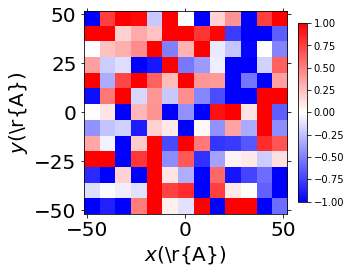

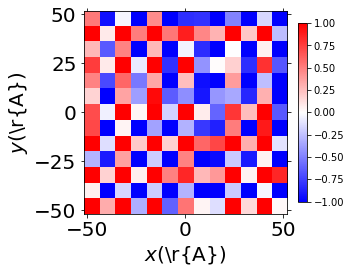

In [67]:
times = np.array(list(lmpData.coord_atoms_broken.keys()))
times = times[ times > (itimee-1) ] #--- equilibration
#
atoml = list(map( lambda x:lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series')), times))
atomd = dict(zip(times,atoml)) #--- dict: key=time val=atom object
#
boxl = list(map(lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] )), times ))
boxd = dict(zip(times,boxl))
#--- attributes for modulus calculatiuons
args = {
         'PLOT': True,
          'MODU':True, 
#          'PATH':'%s/ElasticConst.txt'%path
       }
cplist = [list(map(lambda x: 
          GetPressComp(atomd[x],
                       boxd[x], 
                       y, 
                       PATH = '%s/git/HeaDef/lammpsRuns/NiCoCrNatom100KAnnealedT600Elastic%s/Run0/ElasticConst.txt'%(path,2), **args  ), 
                   times)) 
          for y, indxx in zip(rsub,range(len(rsub)))]
cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list


In [159]:
path

'/Users/Home/Desktop/Tmp/txt'

In [150]:
def Concat(cplist):
    cp={}
    for key in cplist:
#         pdb.set_trace()
        value = reduce(lambda x, y: x+y, list(map(lambda x:x[1],cplist[key]))) #--- concat press.
        valc = reduce(lambda x, y: x+y, list(map(lambda x:x[0],cplist[key]))) #--- concat press.
        try:
            val2 = reduce(lambda x, y: x+y, list(map(lambda x:x[2],cplist[key]))) #--- concat mu.
        except:
            pass
        try:
            cp[key]=[valc,value,val2]
        except:    
            cp[key]=[valc,value]
    return cp
cpdic = Concat(cplist) #--- cpdic[key] = [c,p]

### PDF

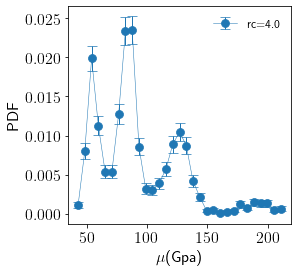

#### variance

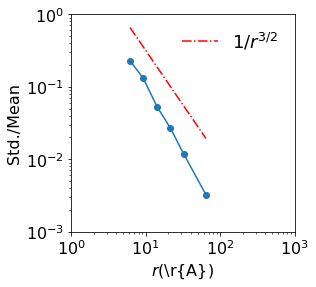

In [24]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
ax.set_ylabel(r'Std./Mean',fontsize=16)
ax.tick_params(labelsize=16)
ax.axis([1e0,1e3,1e-2,1e1])
#ax.axis([1e0,1e3,1e-3,1e0])
PutMinorTicks(ax, LOGY=True,LOGX=True)
#
ax.plot(list(var.keys()),list(map(var.get,var.keys())),'-o')
#
xx=np.array(list(var.keys()))
xx.sort()
ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
#
ax.legend(frameon=False,fontsize=18)
#
plt.savefig('var.png',dpi=75,bbox_inches='tight')
plt.show()

### Plot
#### Separate

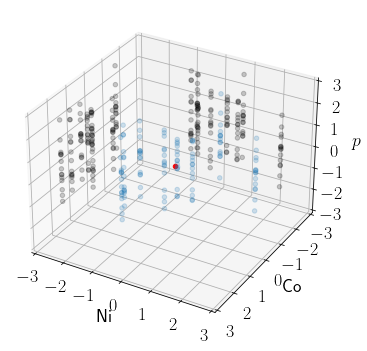

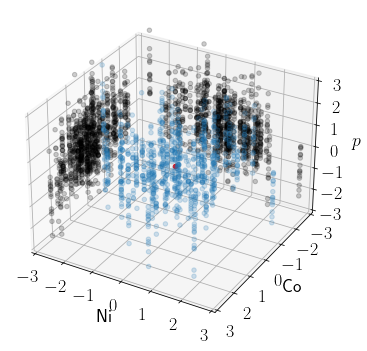

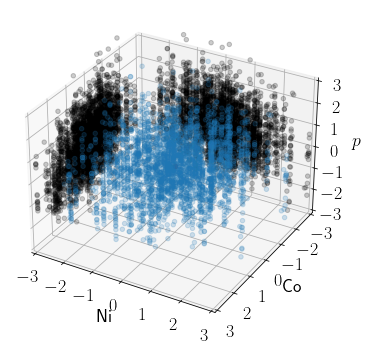

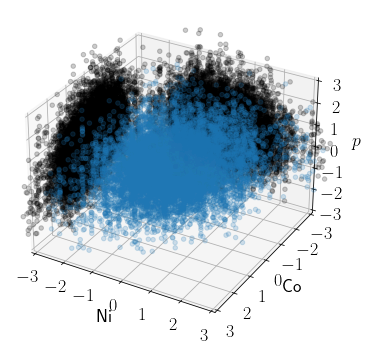

In [360]:
def ScatterPlt3d( clist, plist, 
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[1.0],clist)))
    #
    yy = np.array(list(map(lambda x: x[2.0],clist)))
    #
    zz = plist
    #--- linear fit
    reg = LinearRegression().fit(np.c_[xx,yy], zz)
#     pdb.set_trace()

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        yy = Zscore(yy)
        zz = Zscore(plist)

    #--- plot
    if Plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111,projection='3d')
        #
        ax.set_xlabel(r'Ni',fontsize=18)
        ax.set_ylabel(r'Co',fontsize=18)
        ax.set_zlabel(r'$p$',fontsize=18)
        #
        ax.tick_params(labelsize=18)
        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(sigma,-sigma)
            ax.set_zlim(-sigma,sigma)
            ax.scatter(0,0,0,c='red')
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'][0:4])    
            ax.set_zlim(kwargs['xlim'][4:])

        alpha=0.2
        #
        ax.scatter(xx,yy,zz,
                    alpha=alpha,

                  )

        #--- projection
        xflat = np.full_like(xx, min(ax.get_xlim()))
        yflat = np.full_like(yy, min(ax.get_ylim()))
        zflat = np.full_like(zz, min(ax.get_zlim()))
        #
        ax.scatter(xflat, yy, zz,c='black',alpha=alpha)
        ax.scatter(xx, yflat, zz,c='black',alpha=alpha)
        #
        plt.savefig(kwargs['title'] if 'title' in kwargs else 'scatter.png',
                    dpi=75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return reg.coef_

if not RemoteMachine:

    # ScatterPlt3d( clist, plist, 
    # #               zscore = True, 
    #              xlim=[0.2,0.4,0.4,0.2],
    #                 Plot = True,
    #             )

    d=0.1
    coeffs = list(map(lambda x:
                                ScatterPlt3d( cpdic[x[0]][0], cpdic[x[0]][1], 
                                                zscore = True, 
    #                                          xlim=[0.33-d,.33+d,.33+d,.33-d,-.8,.8],
                                              Plot = True,
                                              title='scatter3d.%s.png'%(x[1]),
                                            ),    
                                zip(rsub,range(10))
                                ))

#### Projections

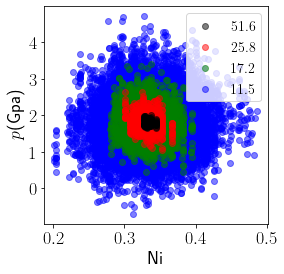

In [377]:
def ScatterPlt2d( clist, plist,
                 ax,
                 color,
                 zorder,
                 rsub=1.0,
                 typee=1.0,
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[typee],clist)))
    #
    zz = plist
    #--- linear fit

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        zz = Zscore(plist)

    #--- plot
    if Plot:

        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(-sigma,sigma)
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])    
        alpha=.5
        ax.scatter(xx, zz,c=color,alpha=alpha,marker='o',
                   zorder=zorder, label='$%2.1f$'%rsub,
                  )

if not RemoteMachine:

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'Ni',fontsize=18)
    ax.set_ylabel(r'$p$(Gpa)',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    #
    d=0.3
    dp=1.8
    list(map(lambda x:
            ScatterPlt2d( cpdic[x[0]][0],cpdic[x[0]][1],
    #                    x[0][0], x[0][1],
                         ax,
                         x[1],
                         x[2],
                         rsub=x[0],
                         typee=1.0,
    #                     zscore = True, 
    #                     xlim=[0.33-d,.33+d,1.8-dp,1.8+dp],
                          Plot = True,
                        ),    
    #        zip(cplist,['black','red','green','blue'],[4,3,2,1],[3600, 3800, 4000, 4200])
            zip(rsub,['black','red','green','blue','C0','orange'],[6,5,4,3,2,1])
            ))

    ax.legend(fontsize=14)
    plt.savefig('scatterNi.png',dpi=2*75,bbox_inches='tight')#,pad_inches=0.0)
    plt.show()


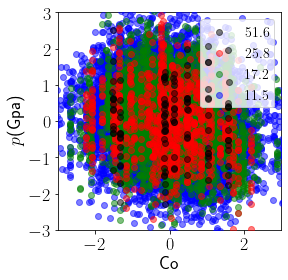

In [379]:
if not RemoteMachine:

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'Co',fontsize=18)
    ax.set_ylabel(r'$p$(Gpa)',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    coeffs = list(map(lambda x:
            ScatterPlt2d( cpdic[x[0]][0],cpdic[x[0]][1],
    #                    x[0][0], x[0][1],
                         ax,
                         x[1],
                         x[2],
                         rsub=x[0],
                         typee=2.0,
                         zscore = True, 
    #                     xlim=[0.33-d,.33+d,1.8-dp,1.8+dp],
                          Plot = True,
                        ),    
    #        zip(cplist,['black','red','green','blue'],[4,3,2,1],[3600, 3800, 4000, 4200])
            zip(rsub,['black','red','green','blue','C0','orange'],[6,5,4,3,2,1])
                                ))
    ax.legend(fontsize=14)
    plt.savefig('scatterCo.png',dpi=2*75,bbox_inches='tight')#,pad_inches=0.0)
    plt.show()


#### altogether

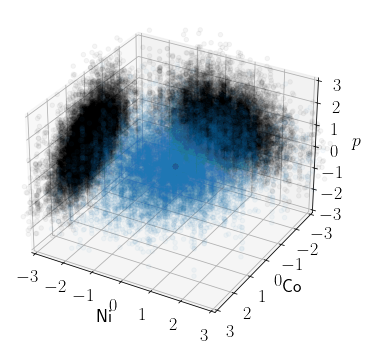

In [382]:
def ScatterPlt3d( clist, plist,
                 ax,
                 color,
                 zorder,
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[1.0],clist)))
    #
    yy = np.array(list(map(lambda x: x[2.0],clist)))
    #
    zz = plist
    #--- linear fit
    reg = LinearRegression().fit(np.c_[xx,yy], zz)
#     pdb.set_trace()

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        yy = Zscore(yy)
        zz = Zscore(plist)

    #--- plot
    if Plot:

        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(sigma,-sigma)
            ax.set_zlim(-sigma,sigma)
            ax.scatter(0,0,0,c='red')
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])    
    #         ax.set_ylim(ax.axis()[3],ax.axis()[2])

        alpha=kwargs['alpha'] if 'alpha' in kwargs else .1
        #
        ax.scatter(xx,yy,zz,
                    alpha=alpha,
                   color='C0'

                  )

        #--- projection
        xflat = np.full_like(xx, min(ax.get_xlim()))
        yflat = np.full_like(yy, min(ax.get_ylim()))
        zflat = np.full_like(zz, min(ax.get_zlim()))
        
        ax.scatter(xflat, yy, zz,c=color,alpha=alpha,zorder=zorder)
        ax.scatter(xx, yflat, zz,c=color,alpha=alpha,zorder=zorder)
        #
    #
    return reg.coef_

if not RemoteMachine:

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111,projection='3d')
    #
    ax.set_xlabel(r'Ni',fontsize=18)
    ax.set_ylabel(r'Co',fontsize=18)
    ax.set_zlabel(r'$p$',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    #
    #ax.set_title(r'$r=%s$ \r{A}, $T=%s^\circ K$'%(17,300),fontsize=18)
    #
    coeffs = list(map(lambda x:
                                ScatterPlt3d( cpdic[x[0]][0], cpdic[x[0]][1],
                                             ax,
                                             'black',#x[1],
                                             1,#x[2],
                                                zscore = True, 
    #                                          xlim=[0.2,0.4,0.4,0.2],
                                              Plot = True,
                                             alpha=0.04,
                                            ),    
                                zip(rsub,range(len(rsub)))
                                ))

    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()


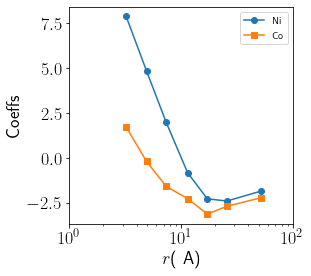

In [127]:
if not RemoteMachine:

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xscale('log')
    ax.set_xlim(1e0,1e2)
    ax.tick_params(labelsize=18)
    ax.set_xlabel('$r$(\r{A})',fontsize=18)
    ax.set_ylabel('Coeffs',fontsize=18)
    #
    ax.plot(rsub,np.array(coeffs)[:,0],'-o',label='Ni')
    ax.plot(rsub,np.array(coeffs)[:,1],'-s',label='Co')

    ax.legend()
    plt.show()

# Neighbor list

In [13]:
if NeighList:
    try:
        !rm neighList.xyz
    except:
        pass
    t0=time.time()
    !ovitos OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff
    print('output neighbor list=%s s'%(time.time()-t0))


rm: neighList.xyz: No such file or directory
InputFile= /Users/Home/Desktop/Tmp/txt/Swapped_800.dump
num_frames= 21
frame=0
frame=10
frame=20
output neighbor list=71.43678593635559 s


In [14]:
if NeighList:
    t0=time.time()
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)
    print('load neighbor list=%s s'%(time.time()-t0))


load neighbor list=66.34363102912903 s


In [15]:
df=lmpNeigh.coord_atoms_broken[0]
df.head()

,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,3,107883.0,2.0,2.486946,-0.076431,-1.802841,-1.711380,-1.0,-1.0,-1.0
1,1,3,104403.0,3.0,2.612948,0.003030,1.879334,-1.815376,0.0,0.0,-1.0
2,1,3,104404.0,2.0,2.280457,1.760996,0.039690,-1.448380,0.0,0.0,-1.0
3,1,3,3483.0,3.0,2.634682,0.037920,-1.963837,1.755978,0.0,-1.0,0.0
4,1,3,3482.0,1.0,2.463939,1.834507,-1.643837,0.058150,0.0,-1.0,0.0


In [16]:
lmpNeigh.coord_atoms_broken.keys()

dict_keys([0, 5000, 10000])

# order parameter
## 2d map

In [ ]:
!mkdir orderParameter

In [94]:
def GridSize(box0, cutoff, dr):
    lx=2*cutoff #box0.CellVector[0,0]
    ly=2*cutoff #box0.CellVector[1,1]
    lz=2*cutoff #box0.CellVector[2,2]
    nx = int(lx/dr)
    ny = int(ly/dr)
    nz = int(lz/dr)
    if nx % 2 == 0:
        nx+=1
    if ny % 2 == 0:
        ny+=1
    if nz % 2 == 0:
        nz+=1
    print('grid size=',nx,ny,nz)
    return (ny,nx,nz), [(-0.5*ly,0.5*ly),(-0.5*lx,0.5*lx),(-0.5*lz,0.5*lz)]


def GetHistd(df, rangee, pair):
    (typei,typej) = pair
    print('pair=',pair)
    #--- filter
    indx = np.all([df.type==typei,df.Jtype==float(typej)], axis=0)
#    display(df[indx])
    #--- binning
    r = np.c_[df[indx][['DX','DY','DZ']]]
    H, edges = np.histogramdd(r, bins = (ny, nx, nz), range=rangee)
    print('H.shape=',H.shape) #, edges[0].size, edges[1].size, edges[2].size
#    assert not np.any(H == 0.0), 'increase bin size!'
    return H


def GetPairProb(df, pairs, rangee ):
#     pair=(2,2)
#     H = GetHistd(
#                     lmpNeigh.coord_atoms_broken[0],
#                     rangee,
#                     pair
#                 )

    H = list(map(lambda x: GetHistd( df, rangee, x),pairs))
    probt = reduce(lambda x, y: x+y, H ) #--- sum
    prob = map(lambda x:H[x]/probt,range(len(pairs)))

    return dict(zip(pairs,list(prob)))





# if SroParameter:
#     #--- partitioning
#     box0 = lp.Box( BoxBounds = lmpData.BoxBounds[4000], AddMissing = np.array([0.0,0.0,0.0] ))
#     (ny,nx,nz), rangee = GridSize( box0, cutoff, .1*dlgr0)
    
#     #--- conditional g(r) 
#     pairs=[(1,1),(1,2),(1,3)]
#     prob = GetPairProb(
#                         lmpNeigh.coord_atoms_broken[4000],
#                         pairs, 
#                         rangee 
#                       )

grid size= 29 29 29
pair= (1, 1)
H.shape= (29, 29, 29)
pair= (1, 2)
H.shape= (29, 29, 29)
pair= (1, 3)
H.shape= (29, 29, 29)


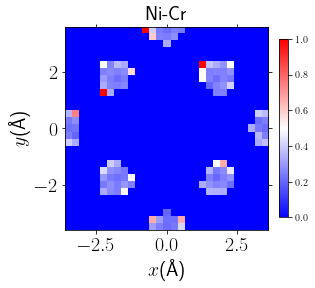

In [98]:
# pairij = (1,3)
# value = prob[pairij][:,:,int(nz/2)].copy()
# value[np.isnan(value)]=0.0

# PltBitmap(value, 
#           xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
#           xlim=[rangee[1][0], rangee[1][-1]],ylim=[rangee[0][0], rangee[0][-1]],
#           zscore = False,
#           frac = 1.0, #--- plot a patch
#           title = 'prob3.png',
#           set_title = 'Ni-Cr',
#           colorbar=True,
#           vminmax=(0.0,1.0),
#         )


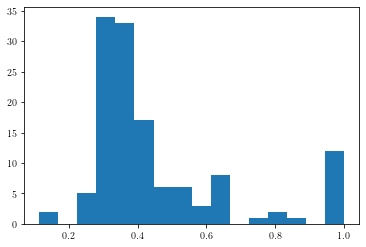

In [93]:
# plt.hist(value[value>0.0],bins=16)
# plt.show()

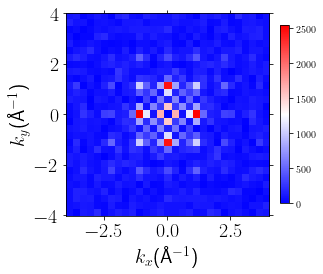

In [77]:
# f=prob[pairij]
# f[np.isnan(f)]=0.0
# f -= np.mean(f)
# f /= np.std(f)

# fq=np.fft.fftn(f)
# fq_shift = np.fft.fftshift(fq)

# value = np.abs(fq_shift)[:,:,int(nz/2)]
# a = 2*cutoff/nx
# PltBitmap(value, 
#           xlabel = r'$k_x$(\r{A}$^{-1}$)', ylabel = r'$k_y$(\r{A}$^{-1}$)',
#           xlim=[-1.0/a, 1.0/a],ylim=[-1.0/a, 1.0/a],
#           zscore = False,
#           frac = 1.0, #--- plot a patch
#           title = 'probq.png',
#           colorbar=True,
#         )

## radial part
### RDF

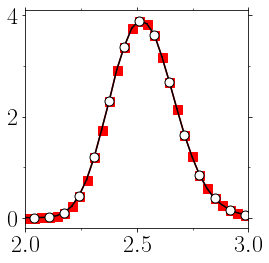

In [18]:
def Wrapper(lmpNeigh,lmpData,itime):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn(  
                  bins=np.linspace(0.0,cutoff,90), 
                  rlist=neigh.DIST )
    return rdf.Get()

if SroParameter:
    itime=list(lmpNeigh.coord_atoms_broken.keys())[1]
    bin_edges1, hist1, err1 = Wrapper(lmpNeigh,lmpData,itime)
    bin_edges0, hist0, err0 = Wrapper(lmpNeigh,lmpData,0)
    #--- plot
    ax = PltErr(bin_edges1,hist1,err1,
          xlim=[2,cutoff],
            attrs={
                   'fmt':'-o',
                   'markersize':9,
                   'markevery':2,
                   'color':'black',
                   'markerfacecolor':'white',
                   'zorder':2,
                  },
                Plot=False
          )

    PltErr(bin_edges1,hist1,err1,
          xlim=[2,cutoff],
    #       ystr='$g(r)$',
    #       xstr='$r$',
           title='orderParameter/gr_sheng.png',
                    attrs={#'label':r'$\mathrm{without~annealing}$',
                           'fmt':'-s',
                           'markersize':9,
                           'markevery':1,
                           'color':'red',
                   'zorder':1,
                          },
                Plot=True,
           ax=ax,
    #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
           fontsize=24,
          )

#### fit a spline

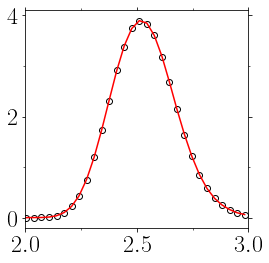

<AxesSubplot:>

In [19]:
def ReturnShapeFunc(x,df):
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg
def Validate(reg, x,y,
             deg_f=np.arange(0,90,5), #np.logspace(0.0,8.0,9,base=2).astype(int),
             cv_samples=10):
    mse={}
    for df in deg_f:
#    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse


# #--- training points
# transfrm = ReturnShapeFunc(bin_edges1,50)
    
# #--- train
# reg = TrainModel(transfrm,np.c_[hist1])

# #--- prediction
# y_pred = reg.predict( transfrm )


# #--- plot
# ax = PltErr(bin_edges1,hist1,err1,
#       xlim=[2,cutoff],
#         attrs={
#                'fmt':'o',
#                'color':'black',
#                'markerfacecolor':'white',
#                'zorder':1,
#               },
#             Plot=False
#       )

# PltErr(bin_edges1,y_pred,
#       xlim=[2,cutoff],
# #       ystr='$g(r)$',
# #       xstr='$r$',
# #       title='orderParameter/gr_sheng.png',
#                 attrs={#'label':r'$\mathrm{without~annealing}$',
#                        'fmt':'-',
#                        'markersize':9,
#                        'markevery':1,
#                        'color':'red',
#                'zorder':2,
#                       },
#             Plot=True,
#        ax=ax,
# #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
#        fontsize=24,
#       )

In [20]:
# mse = Validate(reg, bin_edges1,np.c_[hist1])
# try:
#     keys=mse.keys()
#     plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#     plt.yscale('log')
# #    plt.xscale('log')
# #    plt.ylim(1e-5,1e-2)
# #    plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#     plt.show()
# except:
#     pass

#### 2nd method

peaks of g(r) at:r= [2.51551344]


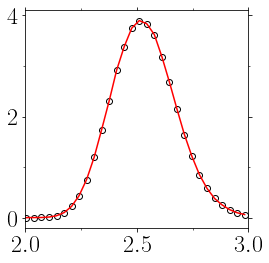

<AxesSubplot:>

In [21]:
def quadratic_spline_roots(spl):
    roots = []
    knots = spl.get_knots()
    for a, b in zip(knots[:-1], knots[1:]):
        u, v, w = spl(a), spl((a+b)/2), spl(b)
        t = np.roots([u+w-2*v, w-u, 2*v])
        t = t[np.isreal(t) & (np.abs(t) <= 1)]
        roots.extend(t*(b-a)/2 + (b+a)/2)
    return np.array(roots)

from scipy.interpolate import InterpolatedUnivariateSpline
r0=2.0
y_axis=hist1
x_axis=bin_edges1
f = InterpolatedUnivariateSpline(x_axis, y_axis, k=3)
cr_pts = quadratic_spline_roots(f.derivative())
cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
cr_pts = cr_pts[cr_pts>r0]
ddf=f.derivative().derivative()
peaks = cr_pts[ddf(cr_pts)<0.0]
print('peaks of g(r) at:r=',peaks)
rpeak = np.sort(peaks)[0]

#--- plot
ax = PltErr(bin_edges1,hist1,err1,
      xlim=[2,cutoff],
        attrs={
               'fmt':'o',
               'color':'black',
               'markerfacecolor':'white',
               'zorder':1,
              },
            Plot=False
      )

PltErr(x_axis,f(x_axis),
      xlim=[2,cutoff],
#       ystr='$g(r)$',
#       xstr='$r$',
#       title='gr_sheng_T800K.png',
                attrs={#'label':r'$\mathrm{without~annealing}$',
                       'fmt':'-',
                       'markersize':9,
                       'markevery':1,
                       'color':'red',
               'zorder':2,
                      },
            Plot=True,
       ax=ax,
#        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
       fontsize=24,
      )

### WC order parameter

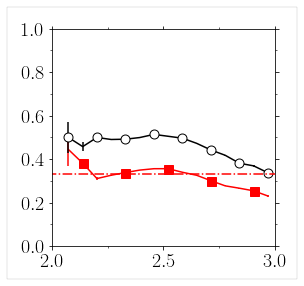

In [22]:
def Wrapper(itime,pairi,pairj):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]

    
    rdf = lp.ComputeRdf(  atoms, box )
    bins = np.linspace(0.0,cutoff,48)
    rdf.PairCrltn(  
                  bins=bins, 
                  rlist=neigh.DIST )
    return rdf.Sro(neigh,pairi,pairj,bins=bins)

    

if SroParameter:
    pairi=1
    pairj=1
    #---
    bin_edges0, p0, dp0 = Wrapper(0,pairi,pairj)
    bin_edges1, p1, dp1 = Wrapper(itime,pairi,pairj)

    ax=    PltErr(bin_edges1,p1,yerr=dp1,
                Plot=False,
                attrs={#'label':r'$\mathrm{with~annealing}$',
                       'fmt':'-o',
                       'markersize':9,
                       'markevery':2,
                       'color':'black',
                       'markerfacecolor':'white',
                       'zorder':2,
                      },
              )
    
    ax = PltErr(bin_edges0,p0,yerr=dp0,
               ax=ax,
                Plot=False,
                attrs={#'label':r'$\mathrm{without~annealing}$',
                       'fmt':'-s',
                       'markersize':9,
                       'markevery':3,
                       'color':'red',
                       'zorder':1,
                      }
              )

    PltErr([0,cutoff],[0.33,0.33],
              xlim=[2,cutoff],
              ylim=[0,1],
               ax=ax,
               attrs={'fmt':'-.r'},
#               title='wc_%s%s_farkas_T800K.png'%(pairi,pairj),
#               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
#               xstr='$r$',
#               legend=True,
#               fontsize=18,
           DrawFrame=[0.2,0.1,0.15,0.1,0.1],
              )

#### temporal fluctuations

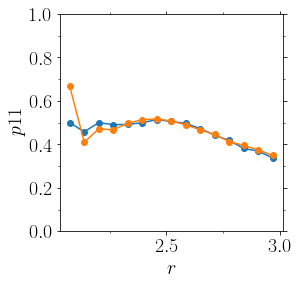

In [23]:
times = list(lmpNeigh.coord_atoms_broken.keys()) #--- list of timesteps
times.pop(0) #--- exclude 0
data = np.c_[list(map(lambda x:Wrapper(x,pairi,pairj)[1],times))].T #--- data corresponding to different times

for indxx in range(data.shape[1]):
    kwargs={} if indxx == 0 else {'ax':ax}
    ax = PltErr(bin_edges1, data[:,indxx],
                Plot=False,
                xstr='r',
                ystr='p11',
                ylim=[0,1],
               **kwargs,
              )

#### average

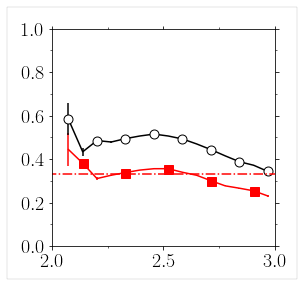

<AxesSubplot:>

In [24]:
times = list(lmpNeigh.coord_atoms_broken.keys()) #--- list of timesteps
times.pop(0) #--- exclude 0
data = np.c_[list(map(lambda x:Wrapper(x,pairi,pairj)[1],times))].T #--- data corresponding to different times
p1 = np.mean(data,axis=1) #--- mean
bin_edges1 = Wrapper(0,pairi,pairj)[0]

#--- plot
ax=    PltErr(bin_edges1,p1,yerr=dp1,
            Plot=False,
            attrs={#'label':r'$\mathrm{with~annealing}$',
                   'fmt':'-o',
                   'markersize':9,
                   'markevery':2,
                   'color':'black',
                   'markerfacecolor':'white',
                   'zorder':2,
                  },
          )

ax = PltErr(bin_edges0,p0,yerr=dp0,
           ax=ax,
            Plot=False,
            attrs={#'label':r'$\mathrm{without~annealing}$',
                   'fmt':'-s',
                   'markersize':9,
                   'markevery':3,
                   'color':'red',
                   'zorder':1,
                  }
          )

PltErr([0,cutoff],[0.33,0.33],
          xlim=[2,cutoff],
          ylim=[0,1],
           ax=ax,
           attrs={'fmt':'-.r'},
           title='orderParameter/wc_%s%s_sheng.png'%(pairi,pairj),
#               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
#               xstr='$r$',
#               legend=True,
#               fontsize=18,
       DrawFrame=[0.2,0.1,0.15,0.1,0.1],
          )

#### difference

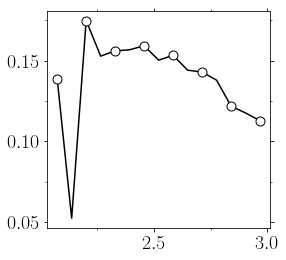

sro size= 2.0


In [28]:
PltErr(bin_edges1,p1-p0,
                Plot=True,
                attrs={#'label':r'$\mathrm{with~annealing}$',
                       'fmt':'-o',
                       'markersize':9,
                       'markevery':2,
                       'color':'black',
                       'markerfacecolor':'white',
                       'zorder':2,
                      },
              )
filtr = np.all([~np.isnan(p1-p0),bin_edges1>rpeak],axis=0)
val=(p1-p0)[filtr]
r_sro = bin_edges1[filtr][val<0.0][0]
print('sro size=',r_sro)
np.savetxt('orderParameter/sroSize.txt',np.c_[temperature,r_sro],header='temp\tsize')
np.savetxt('orderParameter/deltap_r.txt',np.c_[bin_edges1,p1-p0],header='r\tdp')


#### multiple Temperature

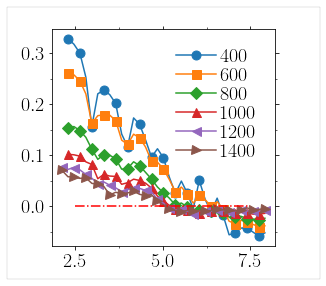

<AxesSubplot:label='c7de156c-3ac4-4d8b-963f-0fef6725b47c'>

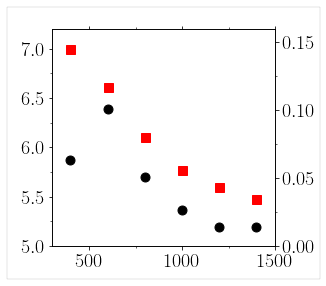

In [114]:
if not RemoteMachine:
    #--- plot order parameter vs. distance
    attrs = {'markevery':2,'markersize':9}
    path = '/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess' #--- path
    ymeans = {}
    for temp, count in zip([400,600,800,1000,1200,1400],range(100)): #--- T
        pathh = path+'/NiCoCrNatom100KTemp%s/Run0/orderParameter/deltap_r.txt'%temp
        try:
            sarray = np.loadtxt(pathh)
            #--- filter
            filtr = ~np.isnan(sarray[:,1])
            #--- order parameter
            sdata = sarray[filtr]
            xdata = sdata[:,0][1:]
            ydata = sdata[:,1][1:]
            #--- mean y
            filtr = ydata > 0.0
            ymean = np.mean(ydata[filtr])
            ymeans[temp]=ymean
            #--- plot
            kwargs = {} if count == 0 else {'ax':ax}
            ax = utl.PltErr(xdata,ydata,
                        Plot=False,
                        **attrs,
                        label=r'$%s$'%temp,
                        **kwargs)

        except:
            continue
            
    utl.PltErr([2.5,7.5],[0,0],
                attrs={'fmt':'-.r'},
                ax=ax,
                Plot=True,
                title='orderParameter/wc_diff_sheng.png',
               legend=True,
            DrawFrame=[0.2,0.2,0.15,0.1,0.1],
            )

    
    #--- plot lengthscale vs. temperature
    for temp, count in zip([400,600,800,1000,1200,1400],range(100)):
        pathh = path+'/NiCoCrNatom100KTemp%s/Run0/orderParameter/sroSize.txt'%temp
        try:
            sarray = np.loadtxt(pathh)
            #--- filter
            xdata = sarray       
            kwargs = {} if count == 0 else {'ax':ax}
            ax = utl.PltErr(xdata[0],xdata[1],
                        Plot=False,
                        attrs={'markersize':9,'color':'black','fmt':'o'},
                        ylim=(5,7.2),
                        xlim=(300,1500),
                        **kwargs)

        except:
            continue

            
utl.PltErr(list(ymeans.keys()),list(map(ymeans.get,ymeans.keys())),
            Plot=False,
            attrs={'markersize':9,'color':'red','fmt':'s'},
            ylim=(0,0.16),
            xlim=(300,1500),
            twinx=True,
            ax=ax,
            DrawFrame=[0.2,0.2,0.15,0.1,0.1],
            title='orderParameter/sroSize_sheng.png',
          )


# Dislocations
## load coordinates

In [37]:

def GetVertexCoords(pathh,box,verbose=False):
    atomss = {}
    lx = box.CellVector[ 0, 0 ]
#    print(lx)
    for myfile in os.listdir(pathh): #--- multiple files
        if verbose:
            print('file=',myfile)
        #--- time step
        indd=myfile.find('.')
        timei=int(myfile[indd+1:])

        #--- read file
        strr=open('%s/%s'%(pathh,myfile)).readlines() #--- read as string
        li = strr.index('DISLOCATIONS 2\n') #--- 1st line to be read
        if verbose:
            print('read line %s '%li)
        li += 1
        
        atomss[timei] = {}
        for ii in range(2):
            dislocation_id = int(strr[li])
            if verbose:
                print('dislocation_id=',dislocation_id)
            #
            li += 3
            n_vertices = int(strr[li]) #--- # of lines
            if verbose:
                print('n_vertices=',n_vertices)
            #
            li+=1
            vertice_xyz=np.c_[list(map(lambda x: x.rsplit(sep=' ')[:3],strr[li:li+n_vertices]))].astype(float)
            li+=n_vertices
            #--- wrap
            tmp=lp.Atoms(x=vertice_xyz[:,0],
                                             y=vertice_xyz[:,1],
                                             z=vertice_xyz[:,2]
            )
            wrap = lp.Wrap(tmp,box)
            wrap.WrapCoord()
            wrap.Set( tmp )
            wrap = lp.Wrap(tmp,box)
            assert np.all(wrap.isInside()), 'aotms outside original box!'
            #--- minimum image
#             pdb.set_trace()
            xc=tmp.x[0]
            tmp.x -= xc
            tmp.x -= (tmp.x >= 0.5*lx) * lx
            tmp.x += (tmp.x < -0.5*lx) * lx
            tmp.x += xc
            atomss[timei][dislocation_id] = tmp
            
    return atomss

if DislocAnl:
    try:
        os.system('rm -r dislocations')
    except:
        pass
    !mkdir dislocations
    #
    !ovitos OvitosCna.py $fileName mydislocations $nevery 5
    !mv mydislocations.* dislocations
    #--- box
    lmpMyData = lp.ReadDumpFile( fileName ) 
    lmpMyData.GetCords( ncount = 1)
    box = lp.Box( BoxBounds = lmpMyData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) )

    #--- load ca files: extract xyz
    atomss = GetVertexCoords('./dislocations', box, verbose=False)
    
    #--- print
    timei=0
    idd=0
    display(pd.DataFrame(atomss[timei][idd].__dict__))


InputFile= /Users/Home/Desktop/Tmp/txt/sheared/shear700MPa_sheng.dump
num_frames= 121
frame=0
frame=60
frame=120


,x,y,z
0,7.580154,59.510178,4.658493
1,7.186621,59.522778,5.377896
2,7.616544,59.554714,6.102753
3,7.811268,60.218994,6.508015
4,8.216616,60.220993,7.253517
...,...,...,...
67,8.183837,60.208286,2.825551
68,8.481449,59.470848,3.155858
69,7.899272,59.318153,3.619627
70,8.217845,59.309696,4.166751


In [8]:
# from mpl_toolkits import mplot3d

# for ii in atomss.keys():
#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     xyz_data=np.c_[atomss[ii].x, atomss[ii].y, atomss[ii].z ]
    
#     zlo=xyz_data[:,2].min()
#     zhi=xyz_data[:,2].max()
#     dz=zhi-zlo
#     ymean=xyz_data[:,1].mean()
#     xmean=xyz_data[:,0].mean()

#     ax.set_zlim(zlo,zhi)
#     ax.set_ylim(ymean-0.5*dz,ymean+0.5*dz)
#     ax.set_xlim(xmean-0.5*dz,xmean+0.5*dz)


#     ax.plot3D(xyz_data[:,0],xyz_data[:,1],xyz_data[:,2] , 'black')
#     plt.show()

## height correlations

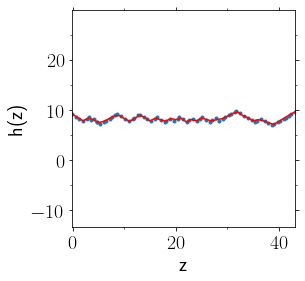

ksi=$=3.03e+00$


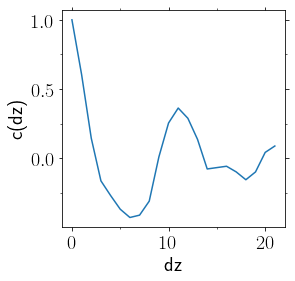

In [41]:
def interp(df,box,timei,verbose=False,Plot=True,**kwargs):
    x=df.z
    y=df.x
    #
    [xlo, xhi, junk]=box.BoxBounds[2].astype(float)
    dx=1.0 #2*np.ceil(np.abs(np.diff(x)).min())
    hist, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx))
    ysum, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx),weights=y)
    ysum2, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx),weights=y*y)
    ymean = ysum / hist
    ysum2 /= hist
    ysum2 -= ymean*ymean
    ystd = (ysum2 / hist)**0.5
    bin_edges = (bin_edges[1:]+bin_edges[:-1])*0.5
    
    if Plot:
        if verbose:
            print('itime=',timei)
        xx=0.5*(x.max()-x.min())
        
        ax=PltErr(x,y,
              attrs={'fmt':'.'},
                Plot=False,
              )
        PltErr(bin_edges,ymean, #yerr=ystd,
              attrs={'fmt':'-r'},
               ax=ax,
                ylim=(np.mean(y)-xx,np.mean(y)+xx),
                xlim=(np.min(x),np.max(x)),
               **kwargs
              )
    
    return bin_edges, ymean, ystd


def Crltn(x,y):
    xq=np.fft.fft(x)
    yq=np.fft.fft(y)
    return np.fft.ifft(np.abs(xq*yq))/len(xq)

def PltCrltn(xint,yint, Plot = True,**kwargs):
#    print(yint.shape)
    crltn = Crltn(zscore(yint),zscore(yint))
    n = xint.shape[0]
    if Plot:
        PltErr((xint-xint[0])[0:int(n/2+n%2)],crltn[0:int(n/2+n%2)],
               attrs={'fmt':'-'},
               Plot = False,
               **kwargs)
    return (xint-xint[0])[0:int(n/2+n%2)],crltn[0:int(n/2+n%2)], xint[crltn<0][0]
        
if DislocAnl:

    zscore = lambda x: (x-np.mean(x))/np.std(x) 


    xint, yint, junk = interp(atomss[timei][idd],box,timei,
                             xstr=r'$z$' if not RemoteMachine else 'z',
                             ystr=r'$h(z)$' if not RemoteMachine else 'h(z)' ,
                             )

    #--- correlation
    junk,  junk, ksi=PltCrltn(xint,yint,
                                xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
                               ystr=r'$\langle h(z)h(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)',

                 )
    print(r'ksi=$=%3.2e$'%ksi)

### multiple timesteps

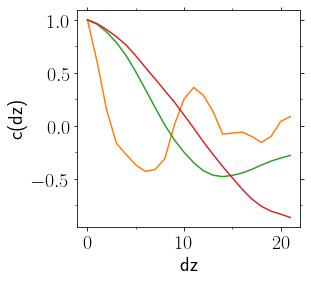

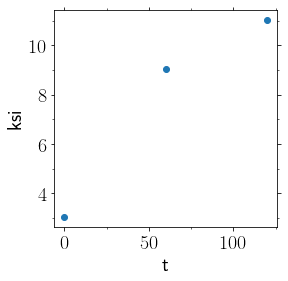

In [48]:
if DislocAnl:
    times = list(atomss.keys())
    times.sort()
    timei = times[0]
    idd=0
    xint, junk, junk = interp(atomss[timei][idd],box,timei,Plot=False)

    #--- interpolate
    yint = np.c_[list(map(lambda x:interp(atomss[x][idd],box,x,Plot=False)[1],times))]
    #--- correlation
    ax=PltErr(None,None,Plot=False)
    ksi = list(map(lambda x:PltCrltn(xint,x,ax=ax,
                                     xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
                                     ystr=r'$\langle h(z)h(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)',
                                    )[2],
                   yint))
    plt.show()

    #--- length
    PltErr(times,ksi,
           attrs={'fmt':'o'},
           xstr=r'$t$' if not RemoteMachine else 't',
           ystr=r'$\xi$' if not RemoteMachine else 'ksi',
          )

### average 

In [57]:
if DislocAnl:
    z = PltCrltn(xint,yint[0],Plot=False)[0]
    cyy = np.c_[list(map(lambda x:PltCrltn(xint,x,Plot=False)[1],yint))]



    cmean = np.mean(cyy,axis=0)
    erry = np.std(cyy,axis=0)/len(cyy)**0.5

    PltErr(z,cmean,yerr=erry,
             xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
             ystr=r'$\langle h(z)h(z^\prime)\rangle$') if not RemoteMachine else 'c(dz)',
    print('ksi_mean=',z[cmean<0][0])
    np.savetxt('dislocations/hcrltn.txt',np.c_[z,cmean,erry],header='z\th(z)\terr')
    np.savetxt('dislocations/hlength.txt',np.c_[temperature,z[cmean<0][0]],header='temp\tksi')

ksi_mean= 11.0


## velocity correlations

h.shape= (3, 44)
v.shape= (2, 44)


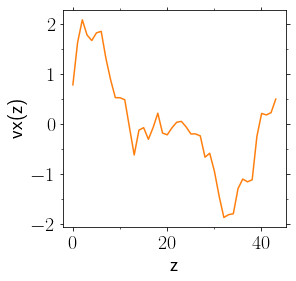

In [52]:
if DislocAnl:
    #--- velocity fluctuations
    print('h.shape=',yint.shape)
    vel=np.diff((yint.T-np.mean(yint,axis=1)),axis=1).T
    vel=(vel.T-np.mean(vel,axis=1)).T
    vel=(vel.T/np.std(vel,axis=1)).T
    print('v.shape=',vel.shape)
    #--- plot
    timei=0
    timef=10
    ax=PltErr(None,None,Plot=False)
    list(map(lambda x:PltErr(xint,x,ax=ax,
                             attrs={'fmt':'-'},
                             Plot=False,
                             xstr=r'$z$' if not RemoteMachine else 'z',
                             ystr=r'$v_x(z)$' if not RemoteMachine else 'vx(z)'),
             vel[timei:timef]))
    plt.show()

### multiple timesteps

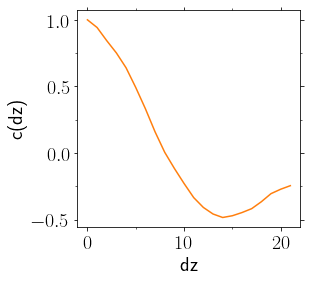

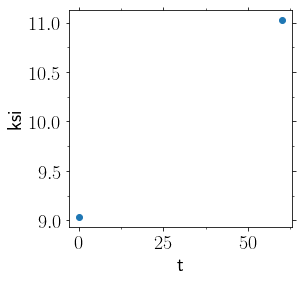

In [54]:
if DislocAnl:
    #--- correlation
    ax=PltErr(None,None,Plot=False)
    list(map(lambda x:PltCrltn(xint,x,ax=ax,
                            xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
                               ystr=r'$\langle v_x(z)v_x(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)'),
             vel[timei:timef]))
    plt.show()

    #--- length
    ksi = list(map(lambda x:PltCrltn(xint,x,ax=ax)[2],vel))
    PltErr(times[:-1],ksi,
           attrs={'fmt':'o'},
           xstr=r'$t$' if not RemoteMachine else 't',
           ystr=r'$\xi$' if not RemoteMachine else 'ksi',
          )

### mean

z.shape= (22,)
cvv.shape= (2, 22)
cmean.shape= (22,)


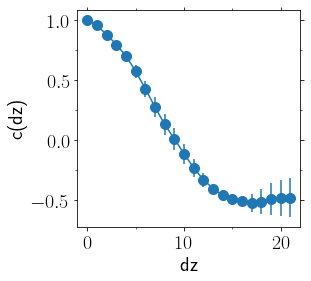

ksi_mean= 10.0


In [58]:
if DislocAnl:
    z = PltCrltn(xint,vel[0],Plot=False)[0]
    print('z.shape=',z.shape)
    cvv = np.c_[list(map(lambda x:PltCrltn(xint,x,Plot=False)[1],vel))]
    print('cvv.shape=',cvv.shape)
    cmean = np.mean(cvv,axis=0)
    print('cmean.shape=',cmean.shape)
    erry = np.std(cvv,axis=0)/len(cvv)**0.5

    PltErr(z,cmean,yerr=erry,
             xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
             ystr=r'$\langle v_x(z).v_x(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)')
    print('ksi_mean=',z[cmean<0][0])
    np.savetxt('dislocations/vxcrltn.txt',np.c_[z,cmean,erry],header='z\tv_x(z)\terr')
    np.savetxt('dislocations/vxlength.txt',np.c_[temperature,z[cmean<0][0]],header='temp\tksi')